In [1]:
import os

if not os.path.exists('data'):
  os.mkdir('data')

In [2]:
# import necessary libraries
import shutil
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers
from tensorflow.keras.layers import Input, Add,Dropout,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D,GlobalMaxPooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/datasets/flowers'

training_dir = 'data/Train'
testing_dir = 'data/Test'

Method 1 : splitting the data

In [5]:
# split data in data_dir as train and test
!pip install split-folders
import splitfolders

# if not os.path.exists(training_dir):
#   os.mkdir(training_dir)

# if not os.path.exists(testing_dir):
#   os.mkdir(testing_dir)
splitfolders.ratio(data_dir, output="data", seed=1337, ratio=(.8, .2))

Copying files: 4327 files [00:29, 145.19 files/s]


In [6]:
# umber of images in train directory
len(list(glob.glob(os.path.join('data/train/*/','*.jpg'))))

3460

In [7]:
# umber of images in test directory
len(list(glob.glob(os.path.join('data/val/*/','*.jpg'))))

867

Method 2: splitting the data

In [8]:
# def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, testing_data_dir=testing_dir, train_test_ratio = 0.8):
#     # Recreate testing and training directories

#     if not os.path.exists(training_data_dir):
#             os.mkdir(training_data_dir)

#     if not os.path.exists(testing_data_dir):
#             os.mkdir(testing_data_dir)

#     num_training_files = 0
#     num_testing_files = 0


#     for subdir, dirs, files in os.walk(all_data_dir):

#         category_name = os.path.basename(subdir)

#         #print(category_name + " vs " + os.path.basename(all_data_dir))
#         if category_name == os.path.basename(all_data_dir):
#               continue

#         #print(files)#,' ',dirs,' ',files)

#         training_data_category_dir = training_data_dir + '/' + category_name
#         testing_data_category_dir = testing_data_dir + '/' + category_name

#         # creating subdir for each sub category
#         if not os.path.exists(training_data_category_dir):
#             os.mkdir(training_data_category_dir)

#         if not os.path.exists(testing_data_category_dir):
#             os.mkdir(testing_data_category_dir)

#         file_list = glob.glob(os.path.join(subdir,'*.jpg'))

#         #print(os.path.join(all_data_dir, subdir))
#         print(str(category_name) + ' has ' + str(len(files)) + ' images')
#         random_set = np.random.permutation((file_list))
#         # copy percentage of data from each category to train and test directory
#         train_list = random_set[:round(len(random_set)*(train_test_ratio))]
#         test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]



#         for lists in train_list :
#             shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
#             num_training_files += 1

#         for lists in test_list :
#             shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
#             num_testing_files += 1


#     print("Processed " + str(num_training_files) + " training files.")
#     print("Processed " + str(num_testing_files) + " testing files.")

# split_dataset_into_test_and_train_sets()

In [9]:
# train and test directory path
training_dir = 'data/train'
testing_dir = 'data/val'

flowers_cls = ['daisy','rose']

In [10]:
flower_path = list(glob.glob(os.path.join(training_dir,flowers_cls[0],'*.jpg')))
flower_path[5]

'data/train/daisy/33810542134_a493f19a71_n.jpg'

In [11]:
# training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training_dir,batch_size=32,labels='inferred',class_names=flowers_cls,
                                                               image_size = (180,180),shuffle=True,seed=123,
                                                               subset='training',
                                                               validation_split=0.2
                                                               )#label_mode='categorical'

Found 1238 files belonging to 2 classes.
Using 991 files for training.


(180, 180, 3)


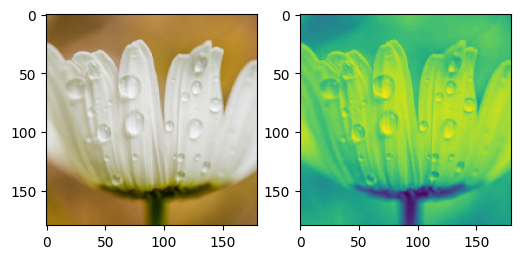

In [12]:
# plot a sample image
import matplotlib.pyplot as plt

for image,labels in train_ds.take(1):
  print(image[0].numpy().astype('uint8').shape)
  plt.figure(figsize=(6,6))
  plt.subplot(1,2,1)
  plt.imshow(image[0].numpy().astype('uint8'))
  plt.subplot(1,2,2)
  plt.imshow(image[0].numpy().astype('uint8')[:,:,0])

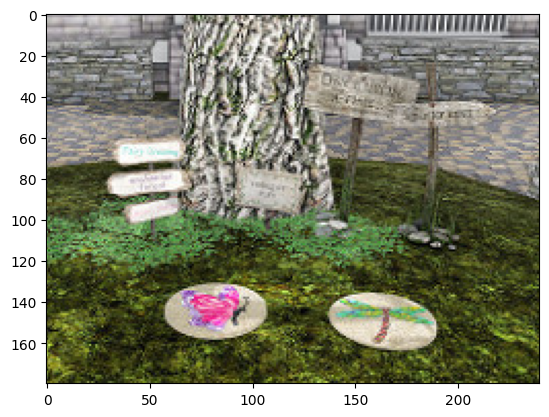

In [13]:
# plot a sample image of daisy
from skimage import io

image = io.imread(flower_path[5])
plt.imshow(image)

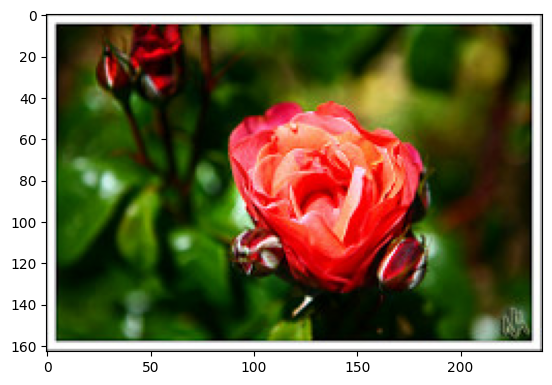

In [14]:
# plot a sample image of rose
flower_path = list(glob.glob(os.path.join(training_dir,flowers_cls[1],'*.jpg')))

image = io.imread(flower_path[10])
plt.imshow(image);

In [15]:
image.shape

(163, 240, 3)

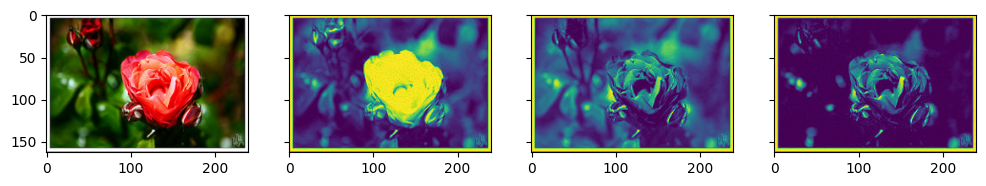

In [16]:
# plotting image and it's RGB channels
f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(12,12),sharey=True)

ax1.imshow(image)
ax2.imshow(image[:,:,0])
ax3.imshow(image[:,:,1])
ax4.imshow(image[:,:,2])

SKIMAGE and OPENCV are commonly used libraries for image processing.
If task at hand is lighter use SKIMAGE

Bring all images to same shape - one of important pre processing step

Binary images are used for image segmentation problem
Also binary images are useful for morphological transformations such as Erosion, dilation etc

In [17]:
# function to plot images
def plot_images(images_arr,imcmap=None):
  plt.figure(figsize=(10,10))
  for i in range(len(images_arr)):
    plt.subplot(1,len(images_arr),i+1)
    plt.imshow(images_arr[i],cmap=imcmap)
    plt.axis('off')
  plt.show()

**Morphological Transformations**

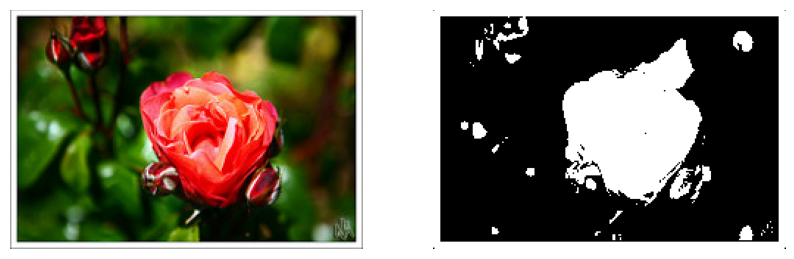

In [18]:
# binary image
bin_image = image[:,:,0] > 125
#print(bin_image)
plot_images([image,bin_image],'gray')

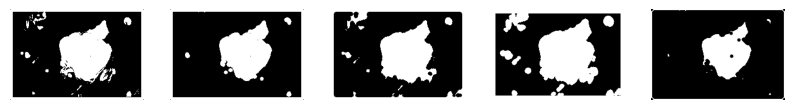

In [19]:
# applying morphological transformations on the image
from skimage.morphology import binary_closing,binary_dilation,binary_erosion,binary_opening
from skimage.morphology import disk

selem = disk(3)

open_img = binary_opening(bin_image,selem)
close_img = binary_closing(bin_image,selem)
dil_img = binary_dilation(bin_image,selem)
ero_img = binary_erosion(bin_image,selem)

plot_images([bin_image,open_img,close_img,dil_img,ero_img],'gray')

Difference in disk size on transformation

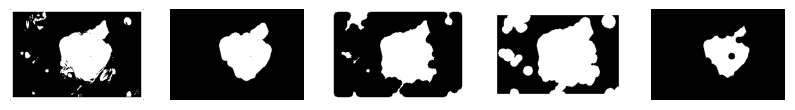

In [20]:
selem = disk(6)

open_img = binary_opening(bin_image,selem)
close_img = binary_closing(bin_image,selem)
dil_img = binary_dilation(bin_image,selem)
ero_img = binary_erosion(bin_image,selem)

plot_images([bin_image,open_img,close_img,dil_img,ero_img],'gray')

**Normalization**

image/255 is used for natural images or RGB scale images

Normalization techniques used in norm2 and norm3 image is for medical images and non natural images. Since the intensity might not be till 255 due to low light conditions or some reasons

If NORM2 method is used and if data has outliers it would reduce the data to very small range. Which is not recommended. So normalizing using percentile method is better.

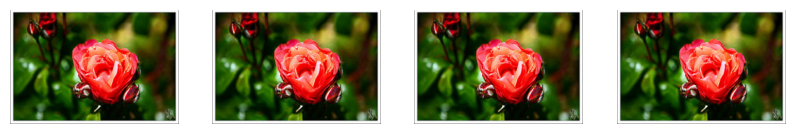

In [21]:
norm1_img = image/255
norm2_img = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_img = (image - np.percentile(image,5))/(np.percentile(image,95) - np.percentile(image,5))

plot_images([image,norm1_img,norm2_img,norm3_img],'gray')

**Augmentation:
Linear transformation and
Affine transformation**

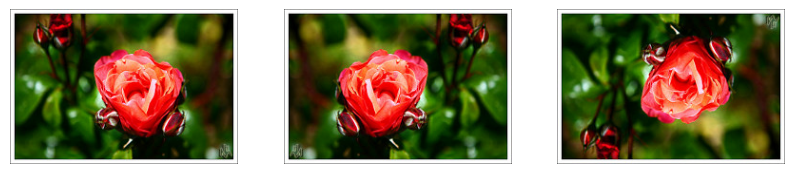

In [22]:
from skimage import transform

# flip left-right and up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_images([image,image_flipr,image_flipud])

Affine Transformation: An affine transformation is a geometric transformation that preserves collinearity and ratios of distances. This means that points that lie on a straight line will remain on a straight line after the transformation, and the ratio of distances between points on a line will be preserved.

In [23]:
image.shape[1]

240

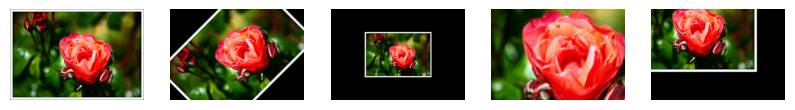

In [24]:
# x and y coordinates for shifting
shift_x,shift_y = image.shape[1]/2, image.shape[0]/2

# translation
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x,-shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x,shift_y])

# rotation
rot_transform = transform.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transform + matrix_to_center
rot_image = transform.warp(image,rot_matrix)

#scaling zoom out
scale_transform = transform.AffineTransform(scale=(2,2))
scale_matrix = matrix_to_topleft + scale_transform + matrix_to_center
scale_image_zoom_out = transform.warp(image,scale_matrix)

# scaling zoom in
scale_transform = transform.AffineTransform(scale=(0.5,0.5))
scale_matrix = matrix_to_topleft + scale_transform + matrix_to_center
scale_image_zoom_in = transform.warp(image,scale_matrix)

#translation
translation_transform = transform.AffineTransform(translation=[50,50])
#translation_matrix = matrix_to_topleft + translation_transform + matrix_to_center
translation_image = transform.warp(image,translation_transform)

plot_images([image,rot_image,scale_image_zoom_out,scale_image_zoom_in,translation_image])


Not using shift by X and Y

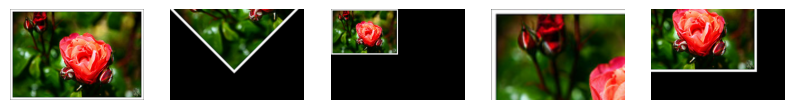

In [25]:
# x and y coordinates for shifting
shift_x,shift_y = image.shape[1]/2, image.shape[0]/2

# translation
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x,-shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x,shift_y])

# rotation
rot_transform = transform.AffineTransform(rotation=np.deg2rad(45))
#rot_matrix = matrix_to_topleft + rot_transform + matrix_to_center
rot_image = transform.warp(image,rot_transform)

#scaling
scale_transform = transform.AffineTransform(scale=(2,2))
#scale_matrix = matrix_to_topleft + scale_transform + matrix_to_center
scale_image_zoom_out = transform.warp(image,scale_transform)

scale_transform = transform.AffineTransform(scale=(0.5,0.5))
#scale_matrix = matrix_to_topleft + scale_transform + matrix_to_center
scale_image_zoom_in = transform.warp(image,scale_transform)

#translation
translation_transform = transform.AffineTransform(translation=[50,50])
#translation_matrix = matrix_to_topleft + translation_transform + matrix_to_center
translation_image = transform.warp(image,translation_transform)

plot_images([image,rot_image,scale_image_zoom_out,scale_image_zoom_in,translation_image])


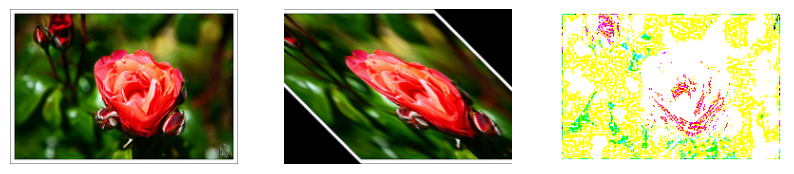

In [26]:
# shear transforms
shear_transform = transform.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft + shear_transform + matrix_to_center
shear_image = transform.warp(image,shear_matrix)

# adding noise to the image
bright_jitter = image * 0.999 + np.zeros_like(image) * 0.001

plot_images([image,shear_image,bright_jitter])

In [27]:
shear_transform

<AffineTransform(matrix=
    [[ 1., -1.,  0.],
     [ 0.,  1.,  0.],
     [ 0.,  0.,  1.]]) at 0x7849e7bfada0>

In [28]:
shear_matrix

<ProjectiveTransform(matrix=
    [[ 1. , -1. , 81.5],
     [ 0. ,  1. ,  0. ],
     [ 0. ,  0. ,  1. ]]) at 0x7849e7bfb730>

In [29]:
matrix_to_topleft

<SimilarityTransform(matrix=
    [[   1. ,   -0. , -120. ],
     [   0. ,    1. ,  -81.5],
     [   0. ,    0. ,    1. ]]) at 0x7849e7bfb4c0>

In [30]:
# importing a resnet model
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/')
import resnet

In [31]:
# normalizing image to 0 - 1
def preprocess_image(image, label):
  # Rescale images to [0, 1]
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [32]:
import pathlib

training_dir = pathlib.Path("data/train")
batch_size = 32
IMAGE_SIZE = (100,100)
img_channels = 3

# training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training_dir,batch_size=32,labels='inferred',class_names=flowers_cls,
                                                               image_size = IMAGE_SIZE,shuffle=True,seed=123,
                                                               subset='training',
                                                               validation_split=0.2
                                                               )#label_mode='categorical'

# number of classes in the dataset
nb_classes = len(train_ds.class_names)

# normalizing the data
train_ds = train_ds.map(preprocess_image)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

# validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(training_dir,batch_size=32,labels='inferred',class_names=flowers_cls,
                                                              image_size = IMAGE_SIZE,seed=123,
                                                              subset="validation",
                                                              validation_split=0.2
                                                              )

# normalizing the data
val_ds = val_ds.map(preprocess_image)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Found 1238 files belonging to 2 classes.
Using 991 files for training.
Found 1238 files belonging to 2 classes.
Using 247 files for validation.


Custom data generator explanation
https://www.youtube.com/watch?v=EkzB6PJIcCA

In [33]:
for img,label in train_ds.take(1):
  print(img.shape)

(32, 100, 100, 3)


In [34]:
# using resnet 18 model
model = resnet.ResnetBuilder.build_resnet_18((img_channels,100,100),nb_classes)
model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

# train the model
model.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 31s 525ms/step - accuracy: 0.6195 - loss: 1.6121 - val_accuracy: 0.5628 - val_loss: 2.3259
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7617 - loss: 1.4597 - val_accuracy: 0.6235 - val_loss: 1.7632
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7976 - loss: 1.3897 - val_accuracy: 0.6559 - val_loss: 1.6115
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8300 - loss: 1.3622 - val_accuracy: 0.7247 - val_loss: 1.4971
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8082 - loss: 1.3426 - val_accuracy: 0.7166 - val_loss: 1.4972
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8430 - loss: 1.3219 - val_accuracy: 0.7530 - val_loss: 1.4658
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8559 - loss: 1.3153 - val_accuracy: 0.8057 - val_loss: 1.4226
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8674 - loss: 1.3061 - val_accuracy: 0.8057 -

**Hyperparameter Tuning - Learning Rate**

In [35]:
from tensorflow.keras import optimizers

# set of learning rates to test
hyper_param_lr = [0.1,0.01,0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []

  def on_epoch_end(self,epoch,logs={}):
    self.losses.append(logs.get('loss'))

# instantiate the losshistory object
history = LossHistory()
plot_data = {}

# train model for each learning rate
for learn in hyper_param_lr:
  print("=="*20 + "LR = ",learn,"=="*20)
  sgd = optimizers.SGD(learning_rate=learn,clipnorm=1.) # clipnorm : clips the gradient to solve exploding gradients
  model = resnet.ResnetBuilder.build_resnet_18((img_channels,100,100),nb_classes)
  model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
  model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[history])

  plot_data[learn] = history.losses

========================================LR =  0.1 ========================================
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.7025 - loss: 1.5278 - val_accuracy: 0.6761 - val_loss: 3.1826
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7858 - loss: 1.4167 - val_accuracy: 0.7206 - val_loss: 1.6748
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8644 - loss: 1.2744 - val_accuracy: 0.6194 - val_loss: 3.0796
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8795 - loss: 1.2505 - val_accuracy: 0.6275 - val_loss: 2.2468
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9112 - loss: 1.1725 - val_accuracy: 0.7490 - val_loss: 1.5469
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9088 - loss: 1.1647 - val_accuracy: 0.7571 - val_loss: 1.4627
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9531 - loss: 1.0621 - val_accuracy: 0.7976 - val_loss: 1.4024
Epoch 8/10
31/31 ━

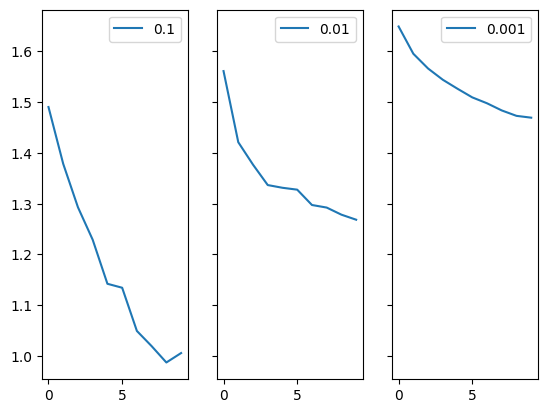

In [36]:
# plot loss vs epochs
fig, axes = plt.subplots(1, len(hyper_param_lr), sharey=True)  # Create subplots with shared y-axis

for i in range(len(hyper_param_lr)):
  axes[i].plot(plot_data[hyper_param_lr[i]], label=hyper_param_lr[i])
  axes[i].legend()

plt.show()

Choosing learning rate of 0.1 after infering the graphs. Practically 0.1 is very high learning rate which should be handled carefully

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# handling learning rate using callback
learn_control = ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,
                                   factor=0.8,min_lr=1e-7)

# gradient clippinng using clipnorm attribute
sgd = optimizers.SGD(learning_rate=0.1,clipnorm=1.)

model = resnet.ResnetBuilder.build_resnet_18((img_channels,100,100),nb_classes)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# train the model
model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[history,learn_control])

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 479ms/step - accuracy: 0.7016 - loss: 1.4957 - val_accuracy: 0.5547 - val_loss: 9.2616 - learning_rate: 0.1000
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7911 - loss: 1.3762 - val_accuracy: 0.7449 - val_loss: 1.5435 - learning_rate: 0.1000
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8426 - loss: 1.3115 - val_accuracy: 0.7773 - val_loss: 1.4039 - learning_rate: 0.1000
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9049 - loss: 1.2146 - val_accuracy: 0.7166 - val_loss: 1.5031 - learning_rate: 0.1000
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8963 - loss: 1.2199 - val_accuracy: 0.7166 - val_loss: 1.5520 - learning_rate: 0.1000
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9555 - loss: 1.0791 - val_accuracy: 0.7652 - val_loss: 1.4356 - learning_rate: 0.1000
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9655 - loss: 1.0664 - val_a

This below code generates augmeted data (32) + original image(32) = 64 images. So 32 augmented images along with 32 original image is fed to network, without saving image to directory. Batch size becomes 64

In [38]:

# import numpy as np
# import tensorflow as tf

# # keras data generator
# # help(ImageDataGenerator)

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

# # data generator with augmentation
# class AugmentedDataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'],
#                  batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = {}
#         self.list_IDs = []
#         self.mode = mode

#         for i, cls in enumerate(flowers_cls):
#             paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
#             brk_point = int(len(paths)*0.8)
#             if self.mode == 'train':
#                 paths = paths[:brk_point]
#             else:
#                 paths = paths[brk_point:]
#             if ablation is not None:
#                 paths = paths[:ablation]
#             self.list_IDs += paths
#             self.labels.update({p:i for p in paths})


#         self.n_channels = n_channels
#         self.n_classes = len(flowers_cls)
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         delete_rows = []

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             img = io.imread(ID)
#             img = img/255
#             if img.shape[0] > 100 and img.shape[1] > 100:
#                 h, w, _ = img.shape
#                 img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
#             else:
#                 delete_rows.append(i)
#                 continue

#             X[i,] = img

#             # Store class
#             y[i] = self.labels[ID]

#         X = np.delete(X, delete_rows, axis=0)
#         y = np.delete(y, delete_rows, axis=0)

#         # data augmentation
#         if self.mode == 'train':
#             aug_x = np.stack([datagen.random_transform(img) for img in X])
#             X = np.concatenate([X, aug_x])
#             y = np.concatenate([y, y])
#         return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [41]:
# Accuracy is not a best metric to monitor so creating a callback to monitor AUC
# since it is a multiclass classification problem using 'ovo: One vs One' method for AUC calculation

from sklearn.metrics import roc_auc_score

class roc_callback(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for x_val,y_val in val_ds:
            y_pred = self.model.predict(x_val)
            # Convert predicted probabilities to class labels
            y_pred_labels = np.argmax(y_pred, axis=1)  # Get the class with highest probability
            y_p.append(y_pred_labels)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p,multi_class='ovo')
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "weights.best.keras"

auc_logger = roc_callback()
# saving model with best performance
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

# data augmentation
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(100,100,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.2,0.2)
  ]
)

# adding data augmentation layer to our resnet model
model = keras.Sequential([
  data_augmentation,
  resnet.ResnetBuilder.build_resnet_18((img_channels,100,100),nb_classes)
])

sgd = optimizers.SGD(learning_rate=0.1,clipnorm=1.)

model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

# train the model
model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=[history,learn_control,
                                                               auc_logger,checkpoint])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step

Val AUC for epoch0: 0.5173913043478261

Epoch 1: val_auc improved from -inf to 0.51739, saving model to weights.best.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.6443 - loss: 1.5907 - val_accuracy: 0.5506 - val_loss: 9.2714 - learning_rate: 0.1000 - val_auc: 0.5174
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Val AUC for epoch1: 0.5924242424242424

Epoch 2: val_auc improved from 0.51739 to 0

**Testing the model**

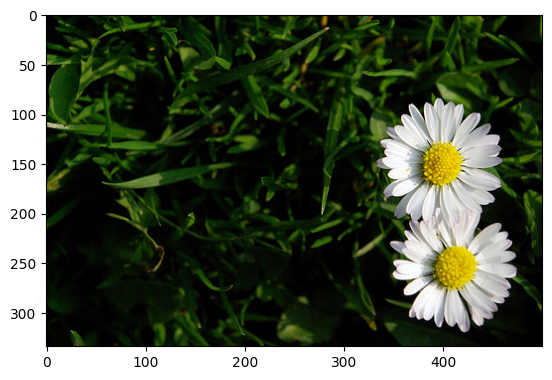

In [43]:
flower_path = list(glob.glob(os.path.join(testing_dir,flowers_cls[0],'*.jpg')))

image = io.imread(flower_path[5])
plt.imshow(image);

In [44]:
h,w,_ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,:]) # The np.newaxis is used to add a batch dimension to the image array

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


array([[1., 0.]], dtype=float32)

Model is correctly predicting it as class 0